
# Linear and Polynomial Regression: Fuel Consumption

**Dataset:** `FuelEconomy.csv`  
**Task:** Predict fuel economy using regression  
**Models:**  
- Linear Regression  
- Polynomial Regression (degree 2, 3, 4)  
**Regularization:** **Not used** (as requested)

In [4]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


## 0.1 Utility functions (Including 70/30 data split)

These are helper functions to reduce repeated code in the rest of the notebook.

---

### What each function does

- **`split_data(X, y)`**  
  Performs a **70% / 30% train-test split** using a fixed `random_state` so that results are reproducible.

- **`prepare_xy(df_in)`**  
  Removes rows with missing values and splits the dataset into:
  - **X** = input features (all columns except the target)  
  - **y** = target variable (here: `Performance Index`)

- **`compute_metrics(y_true, y_pred)`**  
  Computes three standard regression evaluation metrics:
  - **MSE (Mean Squared Error):** penalizes large errors more strongly  
  - **MAE (Mean Absolute Error):** average absolute prediction error  
  - **R² (Coefficient of Determination):** measures how well the model explains the variance in the data

- **`print_fitted_equation(...)`**  
  Prints the fitted regression model equation using the learned coefficients.  
  For polynomial regression, the number of terms can become very large, so the notebook prints only the **top terms** with the largest coefficient magnitude.

- **`plot_actual_vs_predicted_test(...)`**  
  Creates a scatter plot for the **test set** showing:
  - **Actual values** (blue circles)
  - **Predicted values** (red x’s)  
  This helps visually compare how close the predictions are to real values.

- **`run_models_and_evaluate(...)`**  
  This is the main driver function that runs everything for a given scenario:
  - Trains **Linear Regression** and **Polynomial Regression (degrees 2, 3, 4)**
  - Evaluates **train and test** performance using MSE, MAE, and R²
  - Prints fitted equation (top terms)
  - Generates test-set scatter plots
  - Returns a clean results table for easy comparison

---


In [5]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL = "Fuel Economy (MPG)"

def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)



## 1.1 Load the dataset and inspect basic information

In this section, we load the dataset into a pandas DataFrame and perform a **basic sanity check** before building any models.

### What this code does
- **Loads the CSV file** into a pandas DataFrame (`df`)
- Prints the **shape** of the dataset:
  - number of rows = number of samples (students)
  - number of columns = number of features (variables)
- Prints the **column names** to understand what information is available
- Displays the **first few rows** using `head()` to preview the data format and values
- Shows **summary statistics** using `describe()`:
  - for numeric columns: mean, standard deviation, min/max, quartiles, etc.
  - for non-numeric columns: count, unique values, most common value, etc.
- Checks for **missing values** in each column

In [6]:

# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "FuelEconomy.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Shape: (100, 2)

Columns:
['Horse Power', 'Fuel Economy (MPG)']


,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739



Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


,0
Horse Power,0
Fuel Economy (MPG),0



## 1.2 70/30 Data Split, 1.3 Model Training, and 1.4 Model Evaluation

### What the code does
- Trains and evaluates the following models using a **70% / 30% random train-test split**:
  - **Linear Regression**
  - **Polynomial Regression** (degree **2**, **3**, and **4**)
- Reports **Train and Test** metrics:
  - **MSE**, **MAE**, and **R²**
- Prints the fitted model equation (top coefficient terms)
- Plots **Actual vs Predicted** values for the **test set**


Scenario: Fuel Consumption Based on HP
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Fuel Economy (MPG) = 38.8390 (-0.0732) * Horse Power


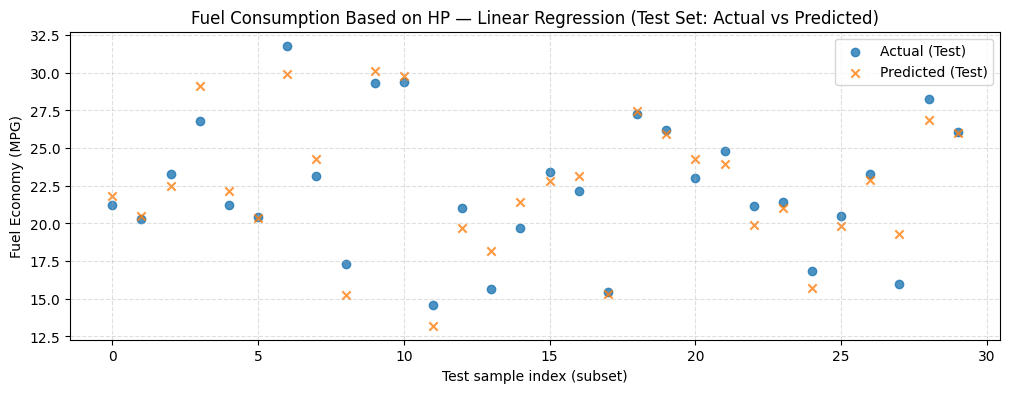


Scenario: Fuel Consumption Based on HP
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Fuel Economy (MPG) = 39.0405 (-0.0754) * Horse Power (+0.0000) * Horse Power^2


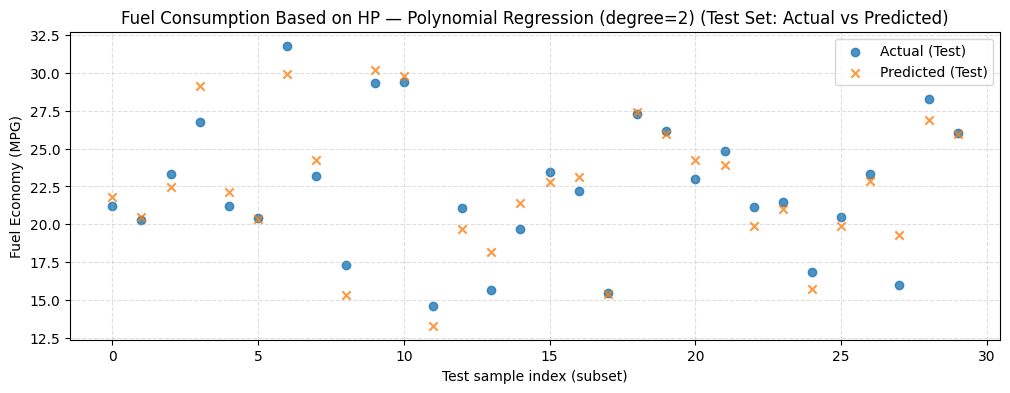


Scenario: Fuel Consumption Based on HP
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Fuel Economy (MPG) = 42.5506 (-0.1394) * Horse Power (+0.0004) * Horse Power^2 (-0.0000) * Horse Power^3


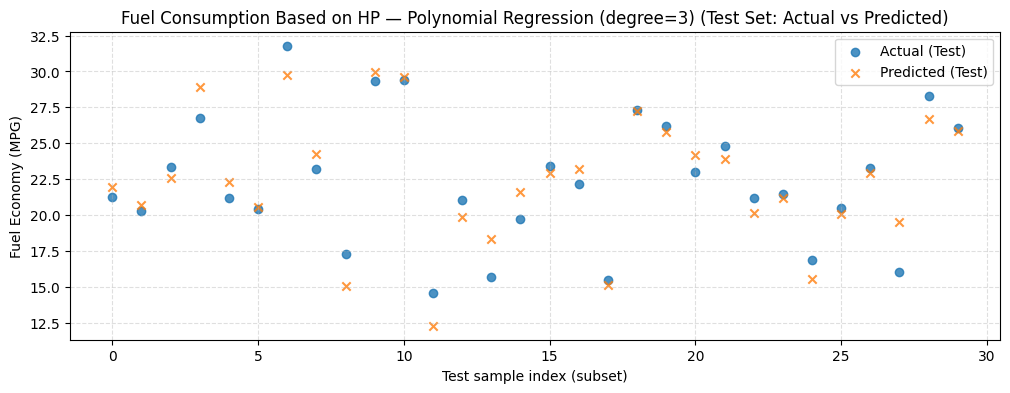


Scenario: Fuel Consumption Based on HP
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Fuel Economy (MPG) = 32.4089 (+0.1406) * Horse Power (-0.0022) * Horse Power^2 (+0.0000) * Horse Power^3 (-0.0000) * Horse Power^4


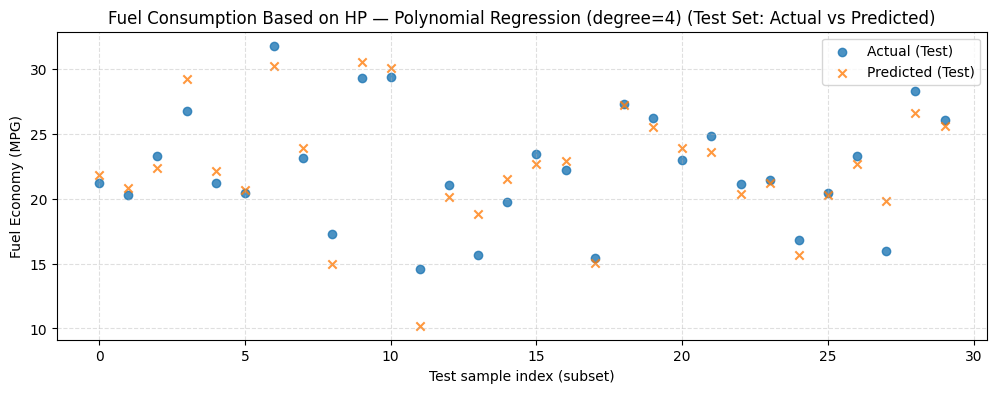

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Fuel Consumption Based on HP,Linear Regression,2.115741,1.209978,0.906320,1.674950,1.031271,0.913315,70,30
1,Fuel Consumption Based on HP,Polynomial Regression (degree=2),2.115070,1.210303,0.906350,1.657031,1.025411,0.914243,70,30
2,Fuel Consumption Based on HP,Polynomial Regression (degree=3),2.060550,1.211527,0.908764,1.903743,1.087196,0.901475,70,30
3,Fuel Consumption Based on HP,Polynomial Regression (degree=4),1.917714,1.168259,0.915088,2.548460,1.203406,0.868108,70,30


In [7]:

# ============================================================
# Part 1: Fuel Consumption Based on HP
# ============================================================

results_part_1 = run_models_and_evaluate(
    df.copy(),
    scenario_name="Fuel Consumption Based on HP",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_part_1)



## 1.5 Discussion and Interpretation

### Questions
• Which model performs best on the test set and why?

  The second degree polynomial model performs the best for my run, supported by metrics with the lowest Test MSE(1.657031), lowest Test MAE(1.025411), and highest Test R^2(0.914243) among all four models.

• Does increasing polynomial degree always improve performance? If not, explain what you observe.

  For my results, increasing polynomial degree does NOT always improve performance. It is true when I increased from linear to second degree there is a boost in performance, however going past that point increasing degrees yields worse results. It looks like second degree here is the sweet spot.

• If a model performs unexpectedly poorly (e.g., low R2 or large test error), propose at least two
plausible reasons.

  There are no models that performs outrageously bad. They all seem to be within reasons.